In [173]:
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [174]:
coins = ['BTC', 'ETH', 'LTC', 'BCH', 'DOGE', 'XRP', 'XEM', 'MIOTA', 'ADA', 'BNB', 'ICX',
         'DOT', 'EOS', 'SOL', 'XLM', 'AAVE', 'DASH', 'NEO', 'ETC', 'XMR', 'WAVES']

df = pd.DataFrame()
i = 0
for coin in coins:
    crypt = web.DataReader(f"{coin}-USD", 'yahoo', '2021-05-01', '2022-07-20')
    crypt['coin'] = coin
    crypt['rank'] = i
    df = df.append(crypt)
    i = i + 1

df.reset_index()
df.to_csv('data_file.csv')

In [175]:
# import data
df = pd.read_csv('data_file.csv')
# Converting the Timestamp column from string to datetime
df['Date'] = pd.to_datetime(df.Date)
df.index = df.Date
df = df.drop('Date', axis=1)
df.head()

,High,Low,Open,Close,Volume,Adj Close,coin,rank
Date,,,,,,,,
2021-05-01,58448.339844,57052.273438,57714.664062,57828.050781,42836427360,57828.050781,BTC,0
2021-05-02,57902.593750,56141.906250,57825.863281,56631.078125,38177405335,56631.078125,BTC,0
2021-05-03,58973.308594,56590.871094,56620.273438,57200.292969,51713139031,57200.292969,BTC,0
2021-05-04,57214.179688,53191.425781,57214.179688,53333.539062,68564706967,53333.539062,BTC,0
2021-05-05,57911.363281,52969.054688,53252.164062,57424.007812,69241316747,57424.007812,BTC,0


In [176]:
# check dataTypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9387 entries, 2021-05-01 to 2022-07-21
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       9387 non-null   float64
 1   Low        9387 non-null   float64
 2   Open       9387 non-null   float64
 3   Close      9387 non-null   float64
 4   Volume     9387 non-null   int64  
 5   Adj Close  9387 non-null   float64
 6   coin       9387 non-null   object 
 7   rank       9387 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 660.0+ KB


In [177]:
# statistical analysis for a single coin, BTC
btc_price = df[df['coin']=='BTC']
btc_price.describe()

,High,Low,Open,Close,Volume,Adj Close,rank
count,447.000000,447.000000,447.000000,447.000000,4.470000e+02,447.000000,447.0
mean,42780.809476,40550.215774,41771.332210,41685.077325,3.395161e+10,41685.077325,0.0
std,11106.721124,10727.755995,10910.174202,10908.101987,1.324705e+10,10908.101987,0.0
min,19371.748047,17708.623047,19010.902344,19017.642578,1.373656e+10,19017.642578,0.0
25%,36265.296875,33655.191406,35334.187500,35164.308594,2.586251e+10,35164.308594,0.0
50%,42478.304688,40625.632812,41501.746094,41502.750000,3.174426e+10,41502.750000,0.0
75%,49166.785156,46802.925781,47749.130859,47696.464844,3.820194e+10,47696.464844,0.0
max,68789.625000,66382.062500,67549.734375,67566.828125,1.263581e+11,67566.828125,0.0


In [178]:
# check for empty rows
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
coin         0
rank         0
dtype: int64

In [179]:
name = df['coin'].unique()
x_currencies = name[:10]
top_10 = df.loc[df['coin'].isin(x_currencies)]
    
fig = px.pie(top_10, values='Volume', names='coin', title='Top 10 by Trading Volume')
fig.show()

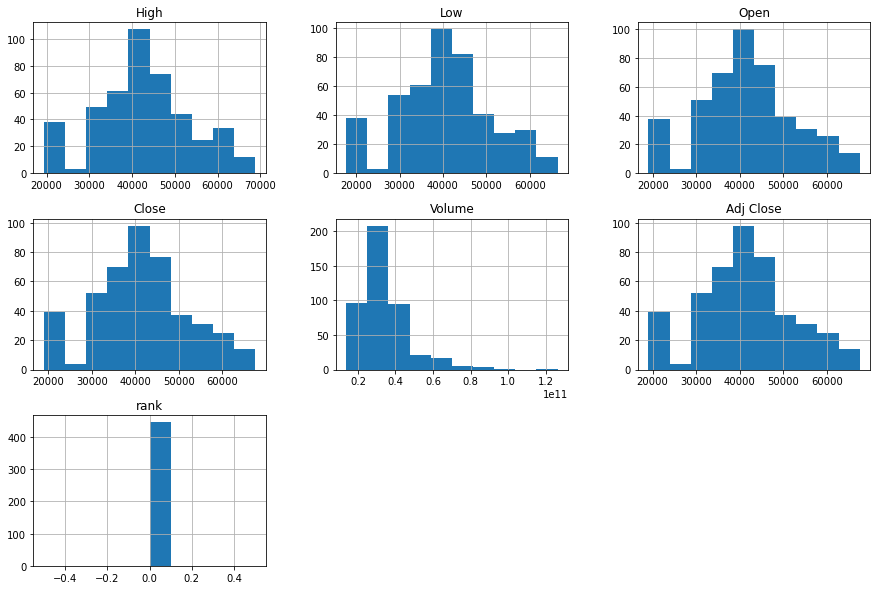

In [180]:
btc_data = df[df['coin']=='BTC'].select_dtypes(exclude = ["bool"])
btc_data.hist(figsize=(15,10))
plt.show()

Text(0.5, 1.0, 'ETH Close Price')

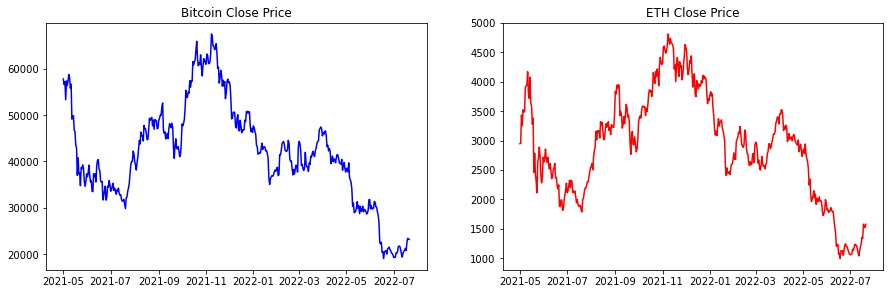

In [181]:
# comparing bitcoin and ethereum close price

fig = plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(df[df['coin']=='BTC'].Close, color="blue")
plt.title('Bitcoin Close Price')

plt.subplot(2, 2, 2)
plt.plot(df[df['coin']=='ETH'].Close, color="red")
plt.title('ETH Close Price')

<AxesSubplot:>

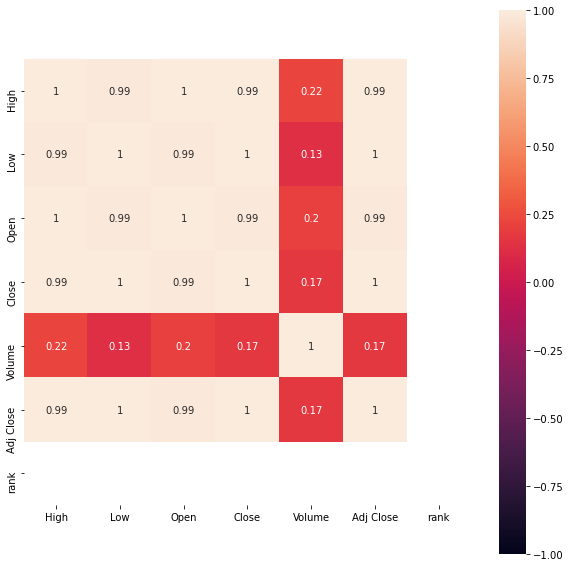

In [182]:
plt.figure(figsize = (10,10))
btc_heatmap = df[df['coin']=='BTC'].corr()
sns.heatmap(btc_heatmap, vmin = -1.0, annot = True, square = True)

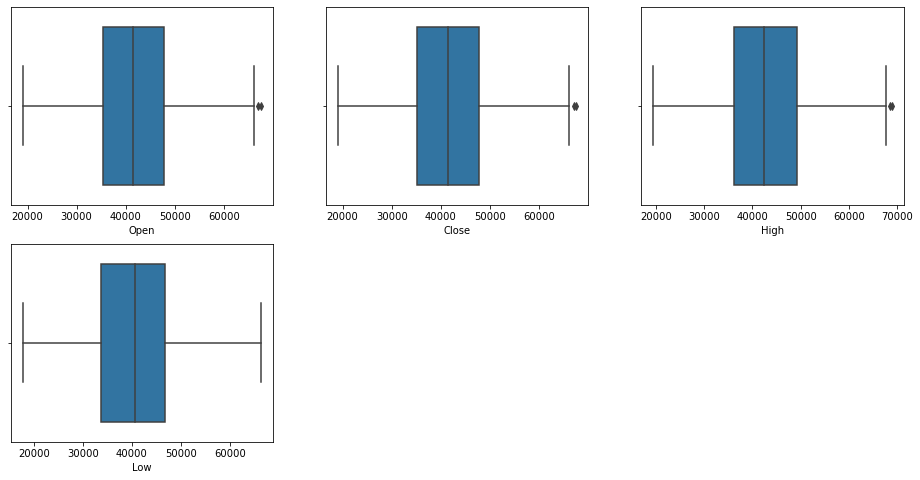

In [183]:
# using box plot to check outliers
data_features = ['Open', 'Close', 'High', 'Low']
index = 0
plt.figure(figsize=(16,8))
for feature in data_features:
    index += 1
    plt.subplot(2, 3, index)
    sns.boxplot(x=feature, data=btc_price)

In [215]:
# feature creation
df2 = df.copy()
feature_1 = []

for coin in coins:
    new_df = df2[df2['coin']==coin] 
    feature_1.extend(new_df.Close.shift(-7))

df2['target'] = feature_1
df2.head()

,High,Low,Open,Close,Volume,Adj Close,coin,rank,target
Date,,,,,,,,,
2021-05-01,58448.339844,57052.273438,57714.664062,57828.050781,42836427360,57828.050781,BTC,0,58803.777344
2021-05-02,57902.593750,56141.906250,57825.863281,56631.078125,38177405335,56631.078125,BTC,0,58232.316406
2021-05-03,58973.308594,56590.871094,56620.273438,57200.292969,51713139031,57200.292969,BTC,0,55859.796875
2021-05-04,57214.179688,53191.425781,57214.179688,53333.539062,68564706967,53333.539062,BTC,0,56704.574219
2021-05-05,57911.363281,52969.054688,53252.164062,57424.007812,69241316747,57424.007812,BTC,0,49150.535156


In [216]:
#calculating missing values in the dataset
df2.isnull().sum()

High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
coin           0
rank           0
target       147
dtype: int64

In [217]:
df2 = df2.dropna()
df2.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
coin         0
rank         0
target       0
dtype: int64

In [218]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

scaled_df = df2.copy()
scaled_df.drop(['coin', 'Adj Close'], axis=1, inplace=True)
scaled_df2 = scaled_df.copy()

scaled_df = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=scaled_df2.columns)

scaled_df.head()

,High,Low,Open,Close,Volume,rank,target
0,0.849668,0.859453,0.854402,0.855864,0.338986,0.0,0.870305
1,0.841734,0.845739,0.856049,0.838149,0.302113,0.0,0.861848
2,0.857299,0.852502,0.838201,0.846574,0.409239,0.0,0.826734
3,0.831727,0.801292,0.846993,0.789345,0.542607,0.0,0.839237
4,0.841862,0.797942,0.788340,0.849885,0.547962,0.0,0.727436


In [219]:
# create input and output variable
X = scaled_df.drop(['Close', 'target'], axis=1)
y = scaled_df.target

In [220]:
# train-test spliting of dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)

In [221]:
model = RandomForestRegressor()

In [222]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted

array([7.02972868e-07, 3.79361394e-04, 7.83410470e-03, ...,
       3.13051205e-04, 8.95316646e-07, 6.28047843e-04])

In [223]:
print(f'R-square: {r2_score(y_test, predicted)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predicted)}')
print(f'Mean Squared Error: {mean_squared_error(y_test, predicted)}')

R-square: 0.9921217164375742
Mean Absolute Error: 0.002196541384481125
Mean Squared Error: 0.00013416388216078208


In [224]:
pred_accuracy = model.score(X_test,y_test)
pred_accuracy

0.9921217164375742

In [225]:
# export model
joblib.dump(model, 'model.sav')

['model.sav']

In [226]:
def get_cryptocurrency(coin_name):
    df = pd.DataFrame()
    crypt = web.DataReader(f"{coin_name}-USD", 'yahoo', '2021-05-01', '2022-07-20')
    coin_rank = coins.index(coin_name)
    crypt['rank'] = coin_rank
    df = df.append(crypt)
    return df

def data_graph(target, data):
    time = str(data.tail(1).index.values[0]).split("T")[0]
    df = data[-target:]['target'].values

    df = pd.DataFrame({'Close': df}, index=pd.date_range(time, periods=target, freq='D'))

    get_plot = pd.concat([data[['Close']], df], sort=False)

    plt.figure(figsize=(15, 6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Crypto Price')
    plt.plot(get_plot[:-(target-1)][['Close']], 'blue', label='Price (USD)')
    plt.plot(get_plot[-target:][['Close']], 'red', label='Target')
    plt.legend()
    plt.show()
    
def myPrediction(coin_name):
    data_df = get_cryptocurrency(coin_name)
    data_df.drop('Adj Close', axis=1, inplace=True)
    copy_data_df = data_df.copy()
    copy_data_df['target'] = copy_data_df['Close']

    # build scale data using csv file
    df = pd.read_csv('data_file.csv')
    df['Date'] = pd.to_datetime(df.Date)
    df['target'] = df['Close']
    df.index = df.Date
    df.drop(['Date', 'Adj Close', 'coin'], axis=1, inplace=True)
    # data scaling
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df)
    scaled_data_df = scaler.transform(copy_data_df)
    df_columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'rank', 'target']
    scaled_data_df = pd.DataFrame(scaled_data_df, columns=df_columns)
#     print(scaled_data_df.head())
    # predict
    rmf = joblib.load('model.sav')
    input_data = scaled_data_df.drop(['Close', 'target'], axis=1)
    scaled_data_df['target'] = rmf.predict(input_data)

    scaled_data_df = scaler.inverse_transform(scaled_data_df)
    scaled_data_df = pd.DataFrame(scaled_data_df, columns=df_columns)
    scaled_data_df.index = data_df.index
    data_df['target'] = scaled_data_df['target']
    
    # plot graph
    data_graph(2, data_df)

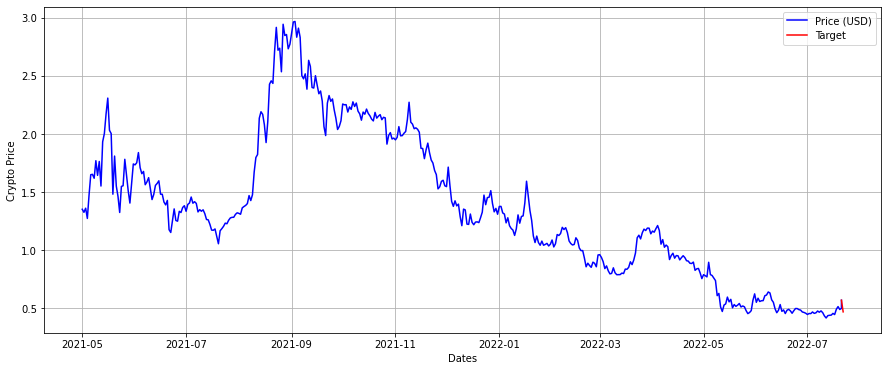

In [227]:
myPrediction('ADA')